In [543]:
import numpy as np
import scipy as sp
from scipy import linalg as sp_linalg
import matplotlib.pyplot as plt
%matplotlib inline

V = 100
rng = np.random.RandomState(0)

power_law_seed = rng.power(a=1.0, size=V)
P_ij = np.triu(rng.lognormal(mean=1, sigma=1, size=[V, V]), k=1)
P_ij *= power_law_seed
P_ij += P_ij.T #P_ij == P_ji
P_ij /= P_ij.sum()

p_i = P_ij.sum(axis=1)
P_i = np.diag(p_i)
P_i_inv = np.diag(1.0 / p_i)
similarities = P_i_inv.dot(P_ij).dot(P_i_inv)

pmis = np.log(similarities)
pmis[pmis == -np.inf] = 0

assert np.allclose(similarities, similarities.T)
assert np.allclose(similarities.dot(P_i).sum(axis=1), 1)
assert np.allclose(P_ij, P_ij.T)
assert np.allclose(pmis, pmis.T)
assert np.allclose(P_i.sum(), 1)
assert np.allclose(P_ij.sum(), 1)

/Users/i.lobov/research/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


In [528]:
p_i.min(), p_i.max()

(3.3518200288626396e-05, 0.00203829024588218)

In [529]:
similarities[similarities != 0].min(), similarities.max()

(0.00012559323636208842, 122.00130811641186)

In [544]:
def mean_relative_squared_error(estimate, original):
    relative_squared_errors = ((estimate - original) / original)**2
    return relative_squared_errors[~np.isnan(relative_squared_errors)].mean()

rng = np.random.RandomState(0)
num_vars = V**2
relative_errors = []
for n in [10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]:
    emp_ij = rng.multinomial(n * num_vars, P_ij.flatten()).reshape([V, V])
    emp_ij = emp_ij / emp_ij.sum()
    P_ij_err = mean_relative_squared_error(emp_ij, P_ij)
    
    emp_i = emp_ij.sum(axis=1)
    P_i_err = mean_relative_squared_error(emp_i, p_i)
    
    emp_i_inv = np.diag(1.0 / emp_i)
    emp_sim = emp_i_inv.dot(emp_ij).dot(emp_i_inv)
    sim_err = mean_relative_squared_error(emp_sim, similarities)
    
    emp_pmi = np.log(emp_sim)
    emp_pmi[emp_pmi == -np.inf] = 0
    pmi_error = mean_relative_squared_error(emp_pmi, pmis)
    
    emp_ppmi = emp_pmi
    emp_ppmi[emp_ppmi < 0] = 0
    ppmi_error = mean_relative_squared_error(emp_ppmi, pmis)
    
    print(n, P_ij_err, P_i_err, sim_err, pmi_error)
    relative_errors.append([n, P_ij_err, P_i_err, sim_err, pmi_error, ppmi_error])

10 0.8264062485920063 0.0016515153203134506 0.8430576588282716 32510.792708312863
100 0.1031439359390243 0.00014124936174386425 0.10060198266395276 1282.2079705610076
1000 0.008930992608056122 1.715521724027633e-05 0.00880290514040422 272.49889993280254
10000 0.0010454427286866151 2.1344827865729785e-06 0.0010365303313143617 21.207011840479677
100000 9.353035199378829e-05 5.441613914116065e-07 9.295833672898068e-05 3.8539126996067905
1000000 9.891576397128798e-06 1.3256828564191539e-08 9.882963873661705e-06 0.13032444603776758
10000000 9.442904122355919e-07 1.3209176915400935e-09 9.412108215765417e-07 0.027880576570688726
100000000 1.0544419170526314e-07 3.0071259973856537e-10 1.0539808692655879e-07 0.0010579162318667173


/Users/i.lobov/research/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/i.lobov/research/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


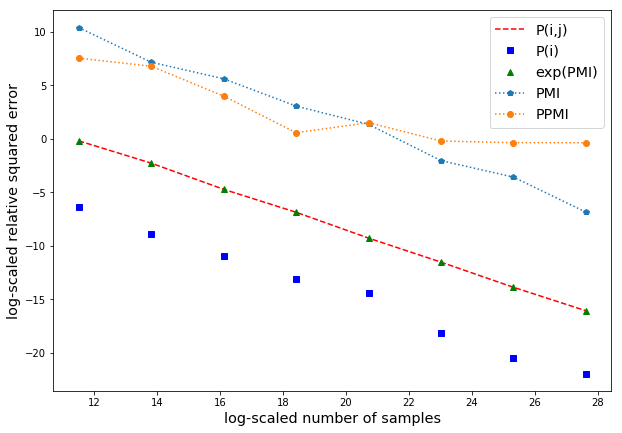

In [559]:
relative_errors = np.asarray(relative_errors).T
x = np.log(relative_errors[0] * V**2)

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(x, np.log(relative_errors[1]), 'r--', label="P(i,j)")
ax.plot(x, np.log(relative_errors[2]), 'bs', label="P(i)")
ax.plot(x, np.log(relative_errors[3]), 'g^', label="exp(PMI)")
ax.plot(x, np.log(relative_errors[4]), 'p:', label="PMI")
ax.plot(x, np.log(relative_errors[5]), 'o:', label="PPMI")

plt.legend(loc='upper right', fontsize="x-large")
plt.xlabel('log-scaled number of samples', fontsize="x-large")
plt.ylabel('log-scaled relative squared error', fontsize="x-large")
plt.show()

In [531]:
num_bins = 5
_, pop_bin_edges = np.histogram(p_i, bins=num_bins)

bin_indices = []
for i in range(num_bins):
    bin_indices.append(np.argwhere(
        np.logical_and(pop_bin_edges[i] <= p_i, p_i < pop_bin_edges[i+1])
    ).flatten())

num_error_samples = 100
res = np.zeros([num_bins, num_bins])

for seed in range(num_error_samples):
    rng = np.random.RandomState(seed)
    n = 100
    num_vars = V**2
    emp_ij = rng.multinomial(n * num_vars, P_ij.flatten()).reshape([V, V])
    emp_ij = emp_ij / emp_ij.sum()
    
    for i in range(num_bins):
        for j in range(num_bins):
            res[-i-1,j] += mean_relative_squared_error(
                emp_ij[bin_indices[i]][:, bin_indices[j]], 
                P_ij[bin_indices[i]][:, bin_indices[j]])
            
res /= num_error_samples

/Users/i.lobov/research/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


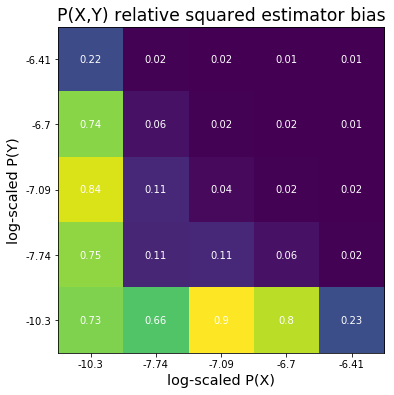

In [532]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(res)
ax.set_xticks(np.arange(num_bins))
ax.set_yticks(np.arange(num_bins))
ax.set_xticklabels(np.log(pop_bin_edges[:-1]).round(2))
ax.set_yticklabels(np.log(pop_bin_edges[:-1][::-1]).round(2))
for i in range(num_bins):
    for j in range(num_bins):
        text = ax.text(j, i, res[i,j].round(2),
                       ha="center", va="center", color="w")
plt.xlabel('log-scaled P(X)', fontsize="x-large")
plt.ylabel('log-scaled P(Y)', fontsize="x-large")
plt.title('P(X,Y) relative squared estimator bias', fontsize="xx-large")
plt.show()

In [533]:
num_bins = 5
_, pop_bin_edges = np.histogram(p_i, bins=num_bins)

bin_indices = []
for i in range(num_bins):
    bin_indices.append(np.argwhere(
        np.logical_and(pop_bin_edges[i] <= p_i, p_i < pop_bin_edges[i+1])
    ).flatten())

num_error_samples = 100
res = np.zeros([num_bins, num_bins])

for seed in range(num_error_samples):
    rng = np.random.RandomState(seed)
    n = 100
    num_vars = V**2
    emp_ij = rng.multinomial(n * num_vars, P_ij.flatten()).reshape([V, V])
    emp_ij = emp_ij / emp_ij.sum()
    emp_i = emp_ij.sum(axis=1)    
    emp_i_inv = np.diag(1.0 / emp_i)
    emp_sim = emp_i_inv.dot(emp_ij).dot(emp_i_inv)
    
    for i in range(num_bins):
        for j in range(num_bins):
            res[-i-1,j] += mean_relative_squared_error(
                emp_sim[bin_indices[i]][:, bin_indices[j]], 
                similarities[bin_indices[i]][:, bin_indices[j]])
            
res /= num_error_samples

/Users/i.lobov/research/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


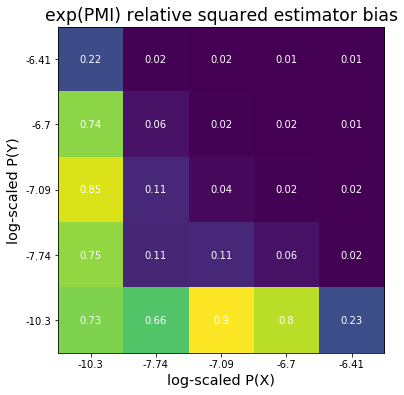

In [534]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(res)
ax.set_xticks(np.arange(num_bins))
ax.set_yticks(np.arange(num_bins))
ax.set_xticklabels(np.log(pop_bin_edges[:-1]).round(2))
ax.set_yticklabels(np.log(pop_bin_edges[:-1][::-1]).round(2))
for i in range(num_bins):
    for j in range(num_bins):
        text = ax.text(j, i, res[i,j].round(2),
                       ha="center", va="center", color="w")
plt.xlabel('log-scaled P(X)', fontsize="x-large")
plt.ylabel('log-scaled P(Y)', fontsize="x-large")
plt.title('exp(PMI) relative squared estimator bias', fontsize="xx-large")
plt.show()

In [535]:
num_bins = 5
_, pop_bin_edges = np.histogram(p_i, bins=num_bins)

bin_indices = []
for i in range(num_bins):
    bin_indices.append(np.argwhere(
        np.logical_and(pop_bin_edges[i] <= p_i, p_i < pop_bin_edges[i+1])
    ).flatten())

num_error_samples = 1000
res = np.zeros([num_bins, num_bins])

for seed in range(num_error_samples):
    rng = np.random.RandomState(seed)
    n = 100
    num_vars = V**2
    emp_ij = rng.multinomial(n * num_vars, P_ij.flatten()).reshape([V, V])
    emp_ij = emp_ij / emp_ij.sum()
    emp_i = emp_ij.sum(axis=1)    
    emp_i_inv = np.diag(1.0 / emp_i)
    emp_sim = emp_i_inv.dot(emp_ij).dot(emp_i_inv)
    emp_pmi = np.log(emp_sim)
    emp_pmi[emp_pmi == -np.inf] = 0
    
    for i in range(num_bins):
        for j in range(num_bins):
            res[-i-1,j] += mean_relative_squared_error(
                emp_pmi[bin_indices[i]][:, bin_indices[j]], 
                pmis[bin_indices[i]][:, bin_indices[j]])
            
res /= num_error_samples

/Users/i.lobov/research/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/Users/i.lobov/research/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [523]:
s = emp_pmi[bin_indices[1]][:, bin_indices[0]]

In [525]:
s_gt = pmis[bin_indices[1]][:, bin_indices[0]]

In [518]:
err = ((s - s_gt)/s_gt)**2
err[~np.isnan(err)].mean()

/Users/i.lobov/research/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


5.920344122804137

In [522]:
err.shape

(12, 12)

In [521]:
err[~np.isnan(err)]

array([1.59177955e-01, 9.82130596e-03, 3.52954666e-02, 5.34555243e-03,
       1.80255636e-01, 4.52273880e-03, 7.41645132e-03, 1.41604171e+00,
       2.41708681e-04, 1.08733683e-02, 1.00000000e+00, 1.59177955e-01,
       2.10293524e-03, 1.71049388e-01, 4.20868904e-03, 9.35974623e+00,
       5.60383478e-02, 1.81473402e-03, 4.01065719e-01, 6.25534624e-01,
       1.00000000e+00, 3.28315062e-02, 5.16986774e-02, 8.57621786e-02,
       1.00397173e+00, 3.81238070e-03, 7.81904382e-05, 1.28929233e+01,
       9.60698156e-01, 5.97713055e-02, 6.13155138e-03, 4.78101803e-02,
       7.26778130e+00, 7.16022015e-03, 7.49390235e-02, 4.35895938e+01,
       1.68995933e-02, 1.41427571e-01, 6.40051745e-03, 3.19193590e-04,
       3.09812241e-01, 3.91721701e-03, 1.80524499e-02, 1.00000000e+00,
       5.34555243e-03, 9.75214252e-03, 3.12377237e-01, 2.80230489e-02,
       8.92888098e-03, 5.59800255e-03, 6.24738743e-02, 4.41052740e-02,
       1.05845617e-02, 1.00000000e+00, 2.98272399e-03, 1.38013298e-01,
      

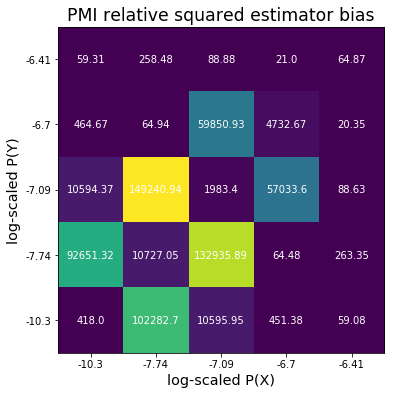

In [537]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(res)
ax.set_xticks(np.arange(num_bins))
ax.set_yticks(np.arange(num_bins))
ax.set_xticklabels(np.log(pop_bin_edges[:-1]).round(2))
ax.set_yticklabels(np.log(pop_bin_edges[:-1][::-1]).round(2))
for i in range(num_bins):
    for j in range(num_bins):
        text = ax.text(j, i, res[i,j].round(2),
                       ha="center", va="center", color="w")
plt.xlabel('log-scaled P(X)', fontsize="x-large")
plt.ylabel('log-scaled P(Y)', fontsize="x-large")
plt.title('PMI relative squared estimator bias', fontsize="xx-large")
plt.show()

In [541]:
num_bins = 5
_, pop_bin_edges = np.histogram(p_i, bins=num_bins)

bin_indices = []
for i in range(num_bins):
    bin_indices.append(np.argwhere(
        np.logical_and(pop_bin_edges[i] <= p_i, p_i < pop_bin_edges[i+1])
    ).flatten())

num_error_samples = 1000
res = np.zeros([num_bins, num_bins])

for seed in range(num_error_samples):
    rng = np.random.RandomState(seed)
    n = 100
    num_vars = V**2
    emp_ij = rng.multinomial(n * num_vars, P_ij.flatten()).reshape([V, V])
    emp_ij = emp_ij / emp_ij.sum()
    emp_i = emp_ij.sum(axis=1)    
    emp_i_inv = np.diag(1.0 / emp_i)
    emp_sim = emp_i_inv.dot(emp_ij).dot(emp_i_inv)
    emp_pmi = np.log(emp_sim)
    emp_pmi[emp_pmi == -np.inf] = 0
    emp_pmi[emp_pmi < 0] = 0 ### PPMI
    
    for i in range(num_bins):
        for j in range(num_bins):
            res[-i-1,j] += mean_relative_squared_error(
                emp_pmi[bin_indices[i]][:, bin_indices[j]], 
                pmis[bin_indices[i]][:, bin_indices[j]])
            
res /= num_error_samples

/Users/i.lobov/research/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/Users/i.lobov/research/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


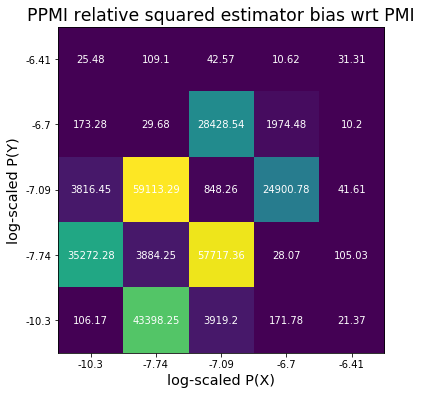

In [542]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(res)
ax.set_xticks(np.arange(num_bins))
ax.set_yticks(np.arange(num_bins))
ax.set_xticklabels(np.log(pop_bin_edges[:-1]).round(2))
ax.set_yticklabels(np.log(pop_bin_edges[:-1][::-1]).round(2))
for i in range(num_bins):
    for j in range(num_bins):
        text = ax.text(j, i, res[i,j].round(2),
                       ha="center", va="center", color="w")
plt.xlabel('log-scaled P(X)', fontsize="x-large")
plt.ylabel('log-scaled P(Y)', fontsize="x-large")
plt.title('PPMI relative squared estimator bias wrt PMI', fontsize="xx-large")
plt.show()